# Character Recognition using Baesian Classifier and Naive Bayes Classifier
Here we are given hand written alphabets and we have to predict the alphabets. We are going to use the Baesian Classifier and Naive Bayes Classifier for the purpose. 

The need for Naive Bayes Classifier is that it is a probabilistic classifier. It is a classifier that can be used to estimate the probability of a sample belonging to a particular class. But as there are large number of features in the data, it is not possible to use the features to calculate the probability. So, comes the need for Naive Bayes Classifier. 

Naive Bayes classifier are surely an approximation of the true probaility, but how good it turns out we will know only after creating the model.

Here we will implement everything first using the tools and libraries provided by the python. Later we will do everything from scratch.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## Lets see how the data look like
First we will import the dataset as a pandas dataframe. This helps us to understand the dataset better and manipulate it better. After that we will identify the features and labels and mark the columns based on the features and labels.
We will also like to know the number of images in the dataset.

In [4]:
# import the images as panda dataframe
df = pd.read_csv('A_Z Handwritten Data.csv')
df.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# column 0 is the class label as they range from 0 to 25

# lest find number of pixels in each image
nFeatures = df.iloc[0, 1:].shape[0]
nFeatures

784

In [6]:
# lets label the coluns properly in the dataframe
pixelsNumbers = ['pixel' + str(i) for i in range(nFeatures)]
columns = ['label'] + pixelsNumbers
df.columns = columns
df.head() 

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# lets store the total number of samples
nSamples = df.shape[0]
nSamples

372450

## Visualising the dataset
Before starting to work on any ML model we should have a clear idea of the dataset. We should visualise sample images of the dataset and also the distribution of the labels.

### How images look like
We can create a color map of the images to see how hand writeen images really look like.

28


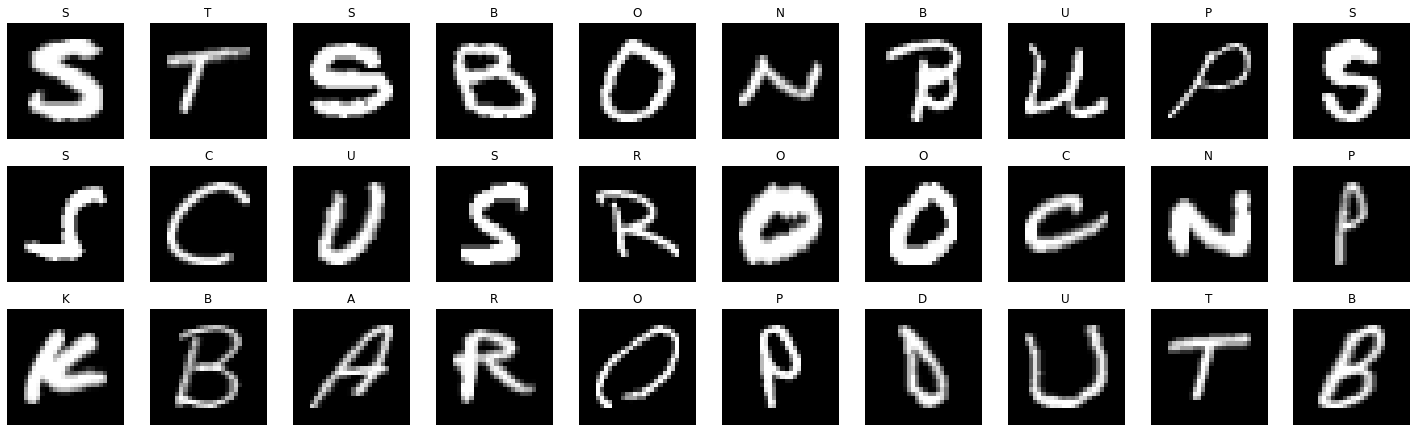

In [8]:
# plotting few images
# we know the fact images are square though this is only needed for the plotting as for the model
# we will use only the features

# we will plot some sample images in a grid
dim = int(nFeatures ** 0.5)
print(dim)

figure = plt.figure(figsize=(20, 20))
for i in range(30):
    # select random image
    index = np.random.randint(0, nSamples)
    image = df.iloc[index, 1:].values.reshape(dim, dim)
    # plot the image
    plt.subplot(10, 10, i + 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    # show the label under the image in  charaters A-Z
    label = chr(df.iloc[index, 0] + 65)
    plt.title(label)
plt.tight_layout()
plt.show()


### Distribution of class labels
We must also know the distribution of the labels. Thid will help us check if all labels are balanced or not. If labels are not balanced then we will have to be cautious about out error metrics.

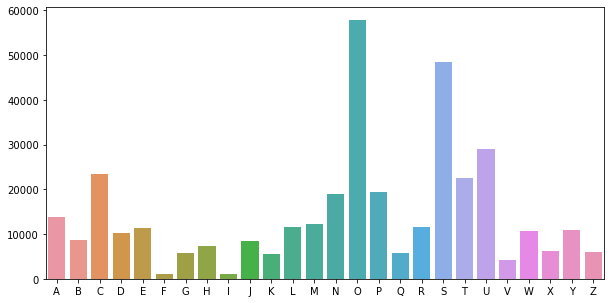

In [9]:
# lets check the distribution of the labels
lCount = df['label'].value_counts()
# lets plot the distribution
plt.figure(figsize=(10, 5))
# convert the index to charaters in the plot
lCount.index = [chr(i + 65) for i in lCount.index]
lCount = lCount.sort_index()
sns.barplot(x=lCount.index, y=lCount.values)
plt.show()

So as we can see all labels are not balanced but the difference is not very large, except for F and I. We can think of reasons for this, as why the data collection is not balanced, or it might be the case that this nature is completly random or created intentioanlly. 

This distribution is surely not due to natural frequency of the labels in the english language as in that case letters like Z, X etc should be less frequent rather than F and I. 

For the time being this is not much a problem for us and we will not bother much, except we will later calculate the error for each class indiviaully as well to see if this has any significant impact on the accuracy.

## Data Preprocessing
Now as we can see the features that are pixels have values ranging from 0 to 255. Now as we have to use Bayesian Classifier, we need to convert the values to range from 0 to 1.

Also we need to create a probabilty distribution for each feature so if features have continuous values and we dont know the distribution so we cant create a effective probability distribution. 

So instead of generating a proability disiribution for each feature we can create a probablity mass function for each feature, but for that we will have to convert the features into descrete values.


In [10]:
# normalising the data
# we will normalise the data by dividing each pixel value by 255
# this will make the data values between 0 and 1

df[pixelsNumbers] = df[pixelsNumbers] / 255


### Discretizing the features
Here the images are basically drawn as white pixels on black background, we can ignore the white intensity and convert the whole image into only two shades complete white or complete black. 

We can chnage every pixel with value more than the half of max value to max and every pixel with value less than the half of max value to 0.

We will also verify if the images remain recognisale to humans or not after this transformation.

In [11]:
# making data descrete
# we will convert every feature to either 0 or 1 as mentioned by the above strategy
# we will use the threshold of 0.5

df[pixelsNumbers] = df[pixelsNumbers] > 0.5     # this will return a boolean array
df[pixelsNumbers] = df[pixelsNumbers].astype(int)   # this will convert the boolean array to int
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


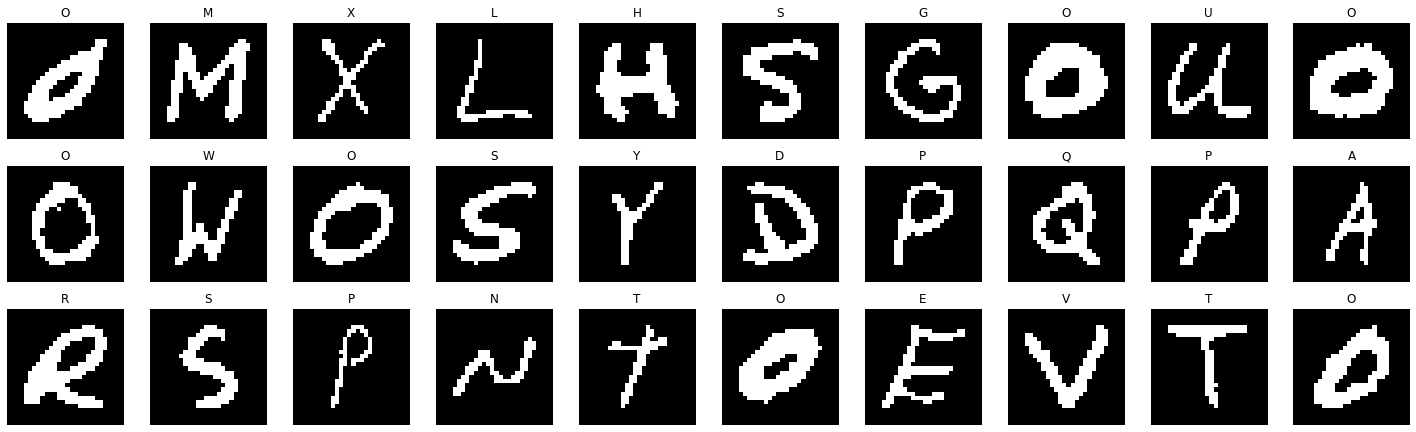

In [12]:
# now lets see how images looks like to humans
# lets plot the images as we did before
figure = plt.figure(figsize=(20, 20))
for i in range(30):
    # select random image
    index = np.random.randint(0, nSamples)
    image = df.iloc[index, 1:].values.reshape(dim, dim)
    # plot the image
    plt.subplot(10, 10, i + 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    # show the label under the image in  charaters A-Z
    label = chr(df.iloc[index, 0] + 65)
    plt.title(label)
plt.tight_layout()
plt.show()



So we can see that images are still recognisable to humans after this transformation, so the amount of information lost for humans are very less. 

### Dividing the data into training and test set
Like any learning model we need to divide the data into training and test set. We will use 80% of the data for training and 20% for testing. We can use other values as well depending on preferences and size of data set available. The split should be random, so we should shuffle the data or atleast the index of the data before splitting. 

In [13]:
# divide the data into train and test
# we will use the inbuilt library function for this
# later we will do everything from scratch as stated earlier
train, test = train_test_split(df, test_size=0.2)
train.shape, test.shape

((297960, 785), (74490, 785))

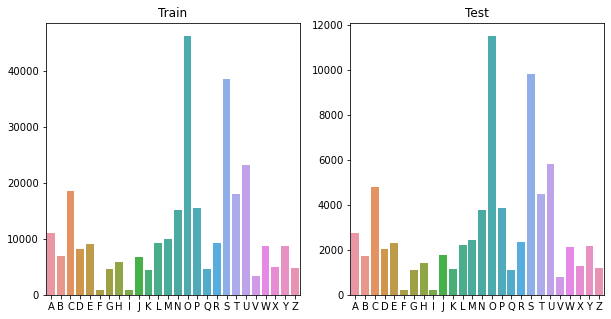

In [18]:

# lets see and plot label distribution in train and test
trainLabels = train['label'].value_counts()
testLabels = test['label'].value_counts()

# plot both the distributions in subplots
figure = plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('Train')
# convert the index to charaters in the plot
trainLabels.index = [chr(i + 65) for i in trainLabels.index]
trainLabels = trainLabels.sort_index()
testLabels.index = [chr(i + 65) for i in testLabels.index]
testLabels = testLabels.sort_index()
sns.barplot(x=trainLabels.index, y=trainLabels.values)
plt.subplot(122)
plt.title('Test')
sns.barplot(x=testLabels.index, y=testLabels.values)


plt.show()

We can see that the distribution partision was random as done by the library, so we do not need to shuffle it.

## Training the model
Now we have divided the data into training and test set, we can train the model. But first we need to understand what is the model and what training the model means.

### Bayesian Classifier
The Bayesian Classifier is a probabilistic classifier. It is a classifier that can be used to estimate the probability of a sample belonging to a particular class. 

### Training a Bayesian Classifier
Training a Bayesian Classifier basically means to know the distribution of the features given a class or a label.

In our case we have features which is the pixel values of the images and labels which is the class of the image. let say them **X**. We also have a label for each image lets call it Y. Each X is of size 784 and each of those 784 values in X can now be 0 or 1.

So here learning the model means learning the probability of each possible or atleast each required value of **X**, given a class or label. i.e.
We need to learn 
\begin{equation}
P(X = [0* 1*]|Y)
\end{equation}
Where [0\* 1\*] means an array of length same as the number of features and each values can be either zero or one .

### Need of Naive Bayes Classifier
So we saw what training a bayes classifier means and how we can train it, so why comes the need of training a naive bayes classifier?

If we stick to the fact that we need the learn probability of each possible value of **X**, given a class or label, then how many probabilities do we need to learn? This will depend on number of possibe values of **X** and number of classes or labels.

Lets see how many possible values of **X** we have to learn for any particular label as here label are only 26 so that will not matter much. So as **X** is of length 784, there are total $2^{784}$ possible values of **X**, this is simply too large and no amount of data we can generate so that we can have enough sample to estimate these probabilities, even the required ones.

Naive Bayes Classifier is an aproximation of calculating that probability. As per Naive Bayes approximation:
\begin{equation}
P(X = someX|Y) = \prod_{i=1}^{784}P(X_i = someX_i|Y)
\end{equation}

So here we assume that all the features are independednt of each other and we can calculate the probability of each feature given a class or label and use it to estimate the probabilty of the whole feature vector.

We used the sikitlearn library to train the model : https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html#sklearn.naive_bayes.CategoricalNB

In [15]:
# lets define the model
# we will use the sklearn library functions for this
import sklearn.naive_bayes as nb

# create and tune the model
model = nb.CategoricalNB()
model.fit(train[pixelsNumbers], train['label'])


CategoricalNB()

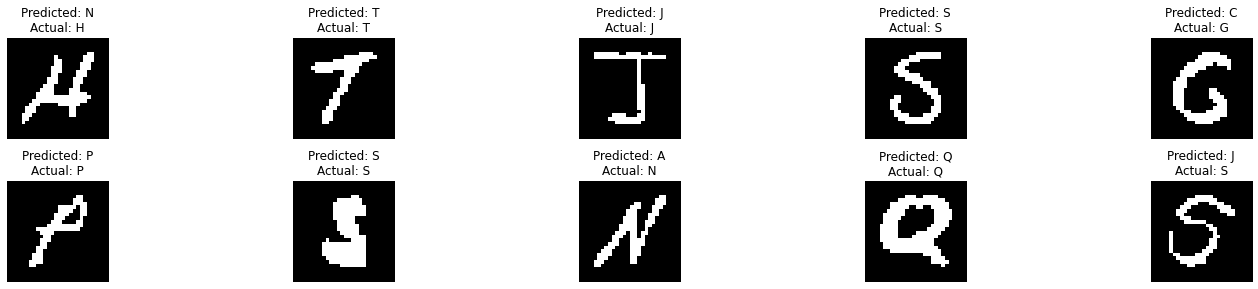

In [16]:
# now the model is trained, lets see how it predicts some of the random images

# we will predict some unseem images from the test data and see the results
# we will also plot the image and the predicted label and actual label
n = 10
figure = plt.figure(figsize=(20, 20))
for i in range(n):
    index = np.random.randint(0, test.shape[0])
    features = test.iloc[index, 1:].values
    label = test.iloc[index, 0]
    image = features.reshape(dim, dim)

    # get the prediction from the model
    prediction = model.predict(features.reshape(1, -1))
    # plot the image as a subplot

    plt.subplot(n, 5, i + 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    # plot the predicted label and actual label
    plt.title('Predicted: ' + chr(prediction[0] + 65) + '\nActual: ' + chr(label + 65))
plt.tight_layout()
plt.show()



## Measuring the performance of the model
Now we have trained the model, we can measure the performance of the model. We will use the accuracy of the model to measure the performance of the model. We have saved our test set for this purpose only.

We will also use the confusion matrix to measure the performance of the model. This is a table that shows the number of correct and incorrect predictions made by the model. 

We will also use the classification report to measure the performance of the model. This is a table that shows the precision, recall, f1-score and support for each class. This is more useful when we have more than two classes and the distribution of the classes is not balanced.



### Error rate of the model on whole test set
Error is simiply the fraction of wrong predictions made by the model. This is just the opposite of accuracies.
\begin{equation}
Error = n_{wrong}/n_{total}
\end{equation}
\begin{equation}
Accuracy = 1 - Error = 1 - (n_{wrong}/n_{total}) = n_{correct}/n_{total}
\end{equation}

In [17]:
# calculating the error using the test data and inbuilt function provided on the model class
score = model.score(test[pixelsNumbers], test['label'])

IndexError: index 1 is out of bounds for axis 1 with size 1

## Creating a Naive Bayes Classifier from scratch
Now as we have exploited the tools and libraries provided by the python, we can create a Naive Bayes Classifier from scratch. This will give us the better uderstanding of the model and how to train it.

### Partisioning the data into test and train
Previously we used inbuilt functions to split the data into test and train set. But now we will do it from scratch.

In [19]:
# partisioning the data into 80:20 
# this time we will do this ourselves

# we will itrate the dataframe row wise and divide it into train and test based on the size
# the distribution will be probabilistic

# first as the data is not suffeled either we can suffle it inplace 
# or we can suffle the index and use them to pick the rows
indexes = np.random.permutation(range(0, nSamples))
trainIndexes = indexes[:int(nSamples * 0.8)]
testIndexes = indexes[int(nSamples * 0.8):]

test = df.iloc[testIndexes, :]
train = df.iloc[trainIndexes, :]


## Creating a Model from scratch
First we will learn the probability distribution for each pixel feature for all the labels. We will store it as a dictionary indexed by label and an array of probabilities for each pixel feature.

In [33]:
# creating and training the model
# we will use the inbuilt library function for this

# lets create a function to create the model
def createModel(train):
    # lets create a dictionary to store the model
    model = {'prior' : [], 'conditional' : {}}
    
    
    # we will group the data by label
    # and then calculate the probabilities for each pixel

    for label in train['label'].unique():
        # get the data for the label
        data = train[train['label'] == label]
        # calculate the probabilities for each pixel
        countPixels = data[pixelsNumbers].sum()
        probPixels = (countPixels + 1) / (data.shape[0] + 2)
        # convert the probabilities to basic numpy array
        probPixels = probPixels.values
        model['conditional'] = {**model['conditional'], **{label: probPixels}}

    # sort the model by the label
    model['conditional'] = {k: v for k, v in sorted(model['conditional'].items(), key=lambda item: item[0])}
    
    # lets calculate the prior probabilities

    # get the total number of labels
    nLabels = train['label'].unique().shape[0]
    # calculate the prior probabilities
    prior = train['label'].value_counts() / nSamples
    # convert the probabilities to basic numpy array
    prior = prior.values
    model['prior'] = prior
    return model
       

In [34]:
model = createModel(train)
print(model.keys())

dict_keys(['prior', 'conditional'])


### Visualising the trained model
Now we have learned the probability distribution for each pixel feature for all the labels. We can see the distribution of the features for each label. We can better visualise it by creating a heat map for each label. We will create gray scale map to see if letters are still visible.

**As the values are binary we are basically storing the probability a pixel is white or 1**, the prbability a pixel is black or 0 will be 1 - probability of pixel being white.

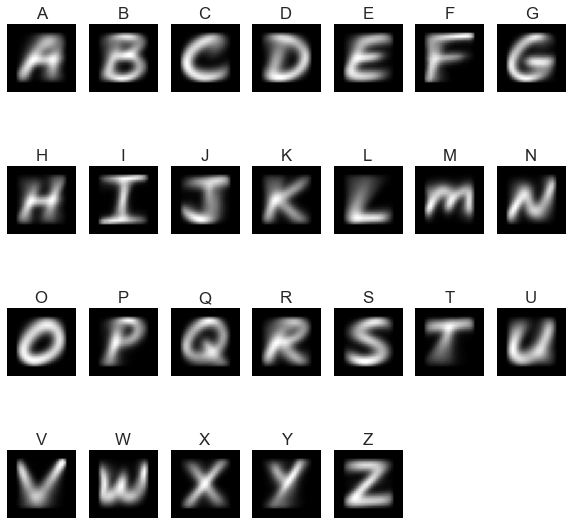

In [54]:
# lets crate heat map of the model for each label

# create figure to plot 26 subplots for A to Z
figure = plt.figure(figsize=(10, 10))
for label in model['conditional'].keys():
    # get the probabilities for the label
    probPixels = model['conditional'][label]
    # plot the heat map
    plt.subplot(4, 7, label + 1)
    plt.title(chr(label + 65))
    plt.imshow(probPixels.reshape(dim, dim), cmap='gray')
    plt.axis('off')



plt.show()


Note that the above plot is not plot of the pixel values but the probabilities learned by the model for each pixel.    

As the values are binary we are basically storing the probability a pixel is white or 1 as stated above.

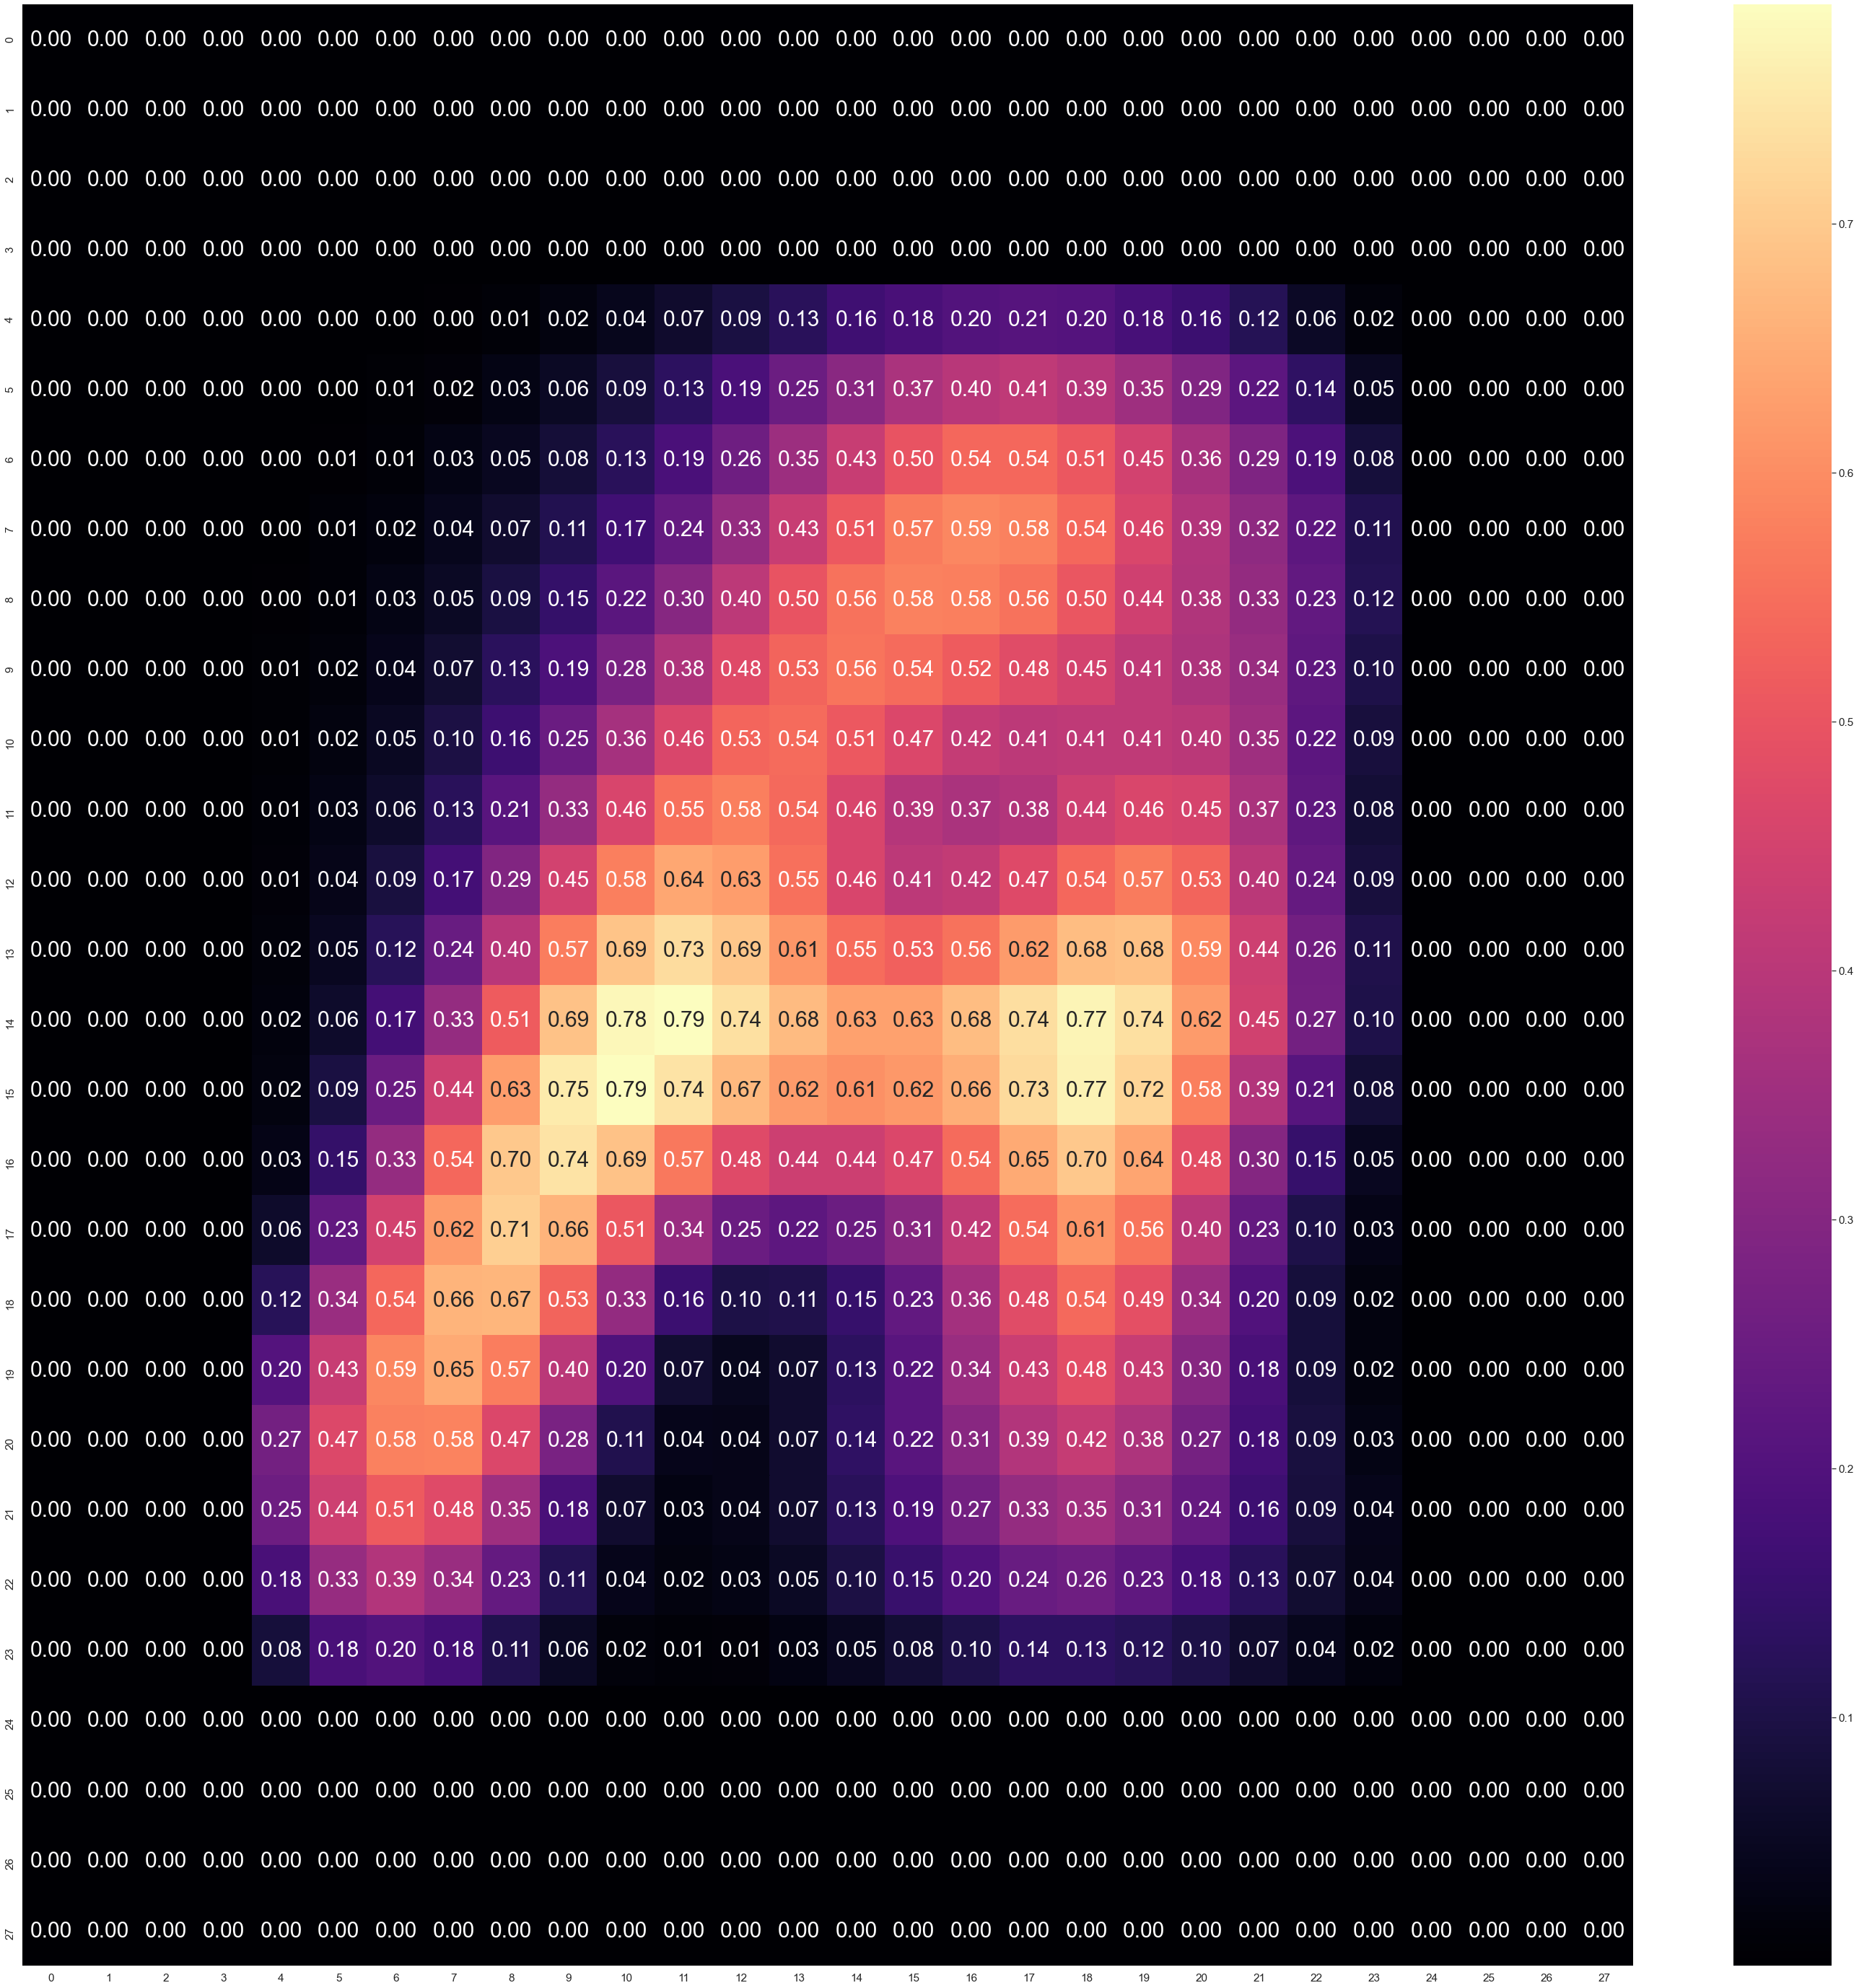

In [56]:
# lest see probabilities for any letter say A
letter =  0 # A

# we will plot the probabilities in a 2d grid as done above
# we will use a color map as well as show the numbers

probData = np.array(model['conditional'][letter]).reshape(dim, dim)

# plot the heat map
sns.heatmap(probData, cmap='magma', annot=True, fmt='.2f')
sns.set(rc = {'figure.figsize':(50,50)} , font_scale = 1.4)

In [28]:
# for fun lets also plot a 3d plot of the probabilities
%conda install -c plotly plotly



Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [ ]:
sns.set(rc = {'figure.figsize':(20,20)} , font_scale = 1.4)

In [57]:
import plotly.graph_objects as go

# lets plot a 3d plot of the probabilities 
fig = go.Figure(data=go.Surface(z=probData))
fig.update_layout(title='Probabilities for letter A', autosize=False, width=800, height=800)  
fig.show()


## Calulating posterior probabilities using Bayes Theorem
As per Bayes Theorem:
\begin{equation}
P(Y = y | X = x) = \frac{P(X = x | Y = y)P(Y = y)} {\sum_{y=1}^{26}P(Y=y)  P(X = x | Y = y)}
\end{equation}

Applying Naiive Bayes Approximation the above equation can be chaged to:
\begin{equation}
P(X = x | Y = y) = \frac{\prod_{i=1}^{784}P(X_i = x_i | Y)P(Y)} {\sum_{y=1}^{26}\prod_{i=1}^{784}P(X_i = x_i | Y = y)P(Y = y)}
\end{equation}

In [63]:
# lets create a posterial probability calculator using the above equation
def calculatePosterior(x, model = model):
    """
    Calculate the posterior probability for each label given a single feature (image)

    Args:
        x (numpy.array): A single feature (image)     
        model (dict): The model  
    Returns:
        numpy.array: The posterior probability for each label
    """
    # get the prior probabilities
    prior = model['prior']
    # get the conditional probabilities
    conditional = model['conditional']
    
    result = np.zeros(26)
    for label in range(26):
        # get the conditional probability for the label
        condProb = conditional[label]
        # if the value for a particluar feature is 1 then we multiply the conditional probability
        # if the value for a particluar feature is 0 then we multiply the 1 - conditional probability 
        
        # condProbBased on the value of the feature
        condProbBasedOnFeature = np.array([condProb[i] if x[i] == 1 else (1 - condProb[i]) for i in range(x.shape[0])])

        # multiply the prior probability and the conditional probability
        result[label] = np.prod(condProbBasedOnFeature) * prior[label]
    return result
    

In [114]:
# function to calculate posterior probability for a batch of features
def calculatePosteriorBatch(X, model = model):
    """
    Calculate the posterior probability for each label given a batch of features (images)

    Args:
        X (numpy.array): A batch of features (images)       
        model (dict): The model
    Returns:
        numpy.array: The posterior probability for each label
    """
    # get the number of samples
    nSamples = X.shape[0]
    # create an empty array to store the results
    result = []
    # calculate the posterior probability for each sample
    for i in range(nSamples):
        result.append(calculatePosterior(X[i], model))
    return np.array(result)
    
    

In [115]:
def predict(model, x):
    """
    This function predicts the label of the image x.
    """
    # Get the posterior probabilities of the image x
    posterior = calculatePosterior(x, model)
    # Get the index of the maximum value in the posterior probabilities
    return np.argmax(posterior)

In [120]:
def predictBatch(model, X):
    """
    This function predicts the labels of the images in X.
    """
    # Get the posterior probabilities of the images in X
    posterior = calculatePosteriorBatch(X, model)
    # Get the index of the maximum value in the posterior probabilities
    return np.argmax(posterior, axis=1)

Now before calculating accuracies etc lets predict few examples from the test set as we did for previous section.

(74490, 784) (74490,)


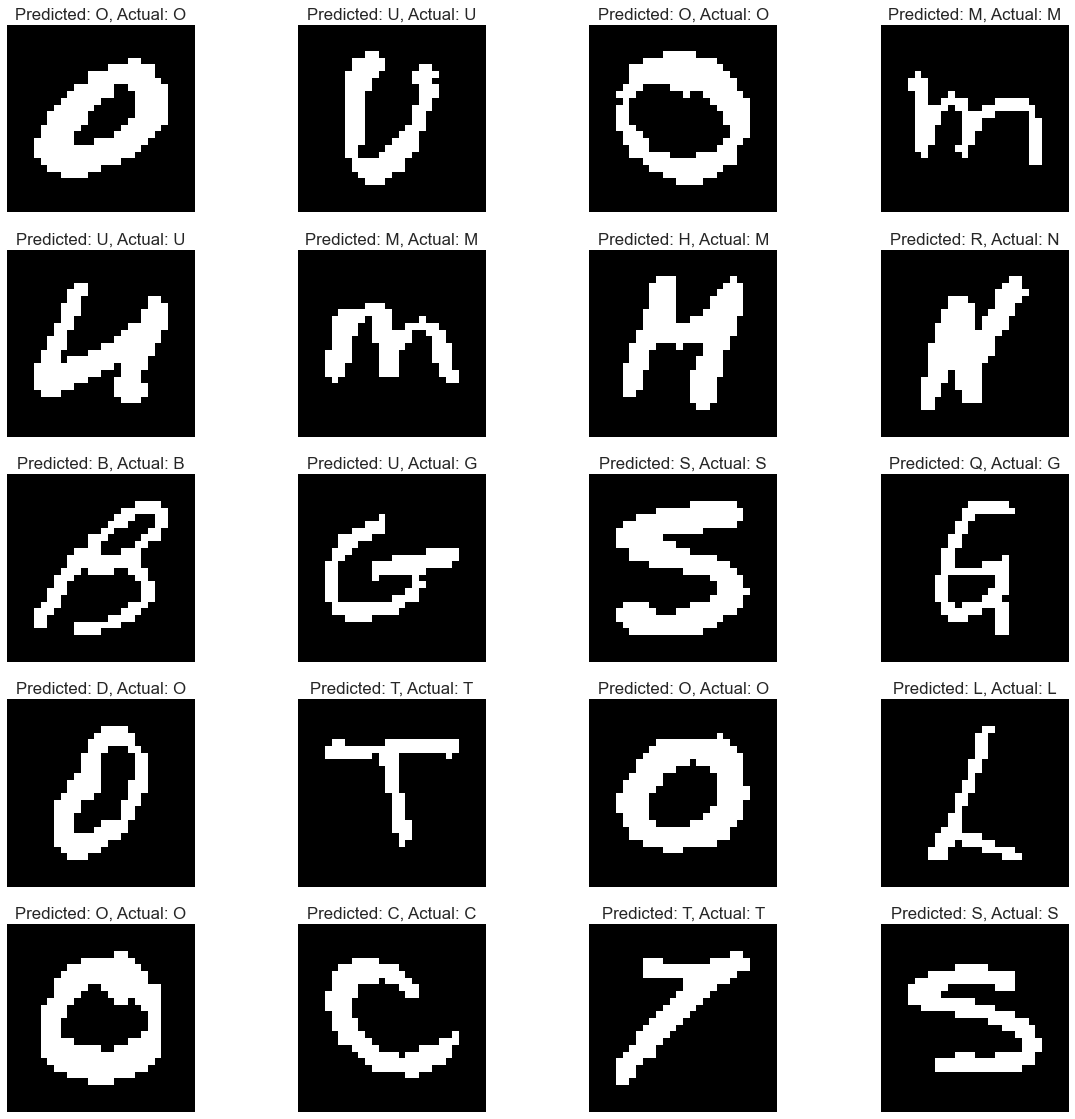

In [118]:
# select few radom images from the test data
testFeatures = test[pixelsNumbers]
testLabels = test['label']
print(testFeatures.shape, testLabels.shape)
figure = plt.figure(figsize=(20, 20))
for i in range(20):
    index = np.random.randint(0, testFeatures.shape[0])
    x = testFeatures.iloc[index]
    y = testLabels.iloc[index]
    y_pred = predict(model, x)
    # plot the image as a gray scale image sub plot
    plt.subplot(5, 4, i + 1)
    plt.imshow(x.values.reshape(dim, dim), cmap='gray')
    plt.axis('off')
    # plot the predicted label and actual label
    plt.title('Predicted: {}, Actual: {}'.format(chr(y_pred + 65), chr(y + 65)))
plt.tight_layout
plt.show()




### Now calculate error metrics for whole test set using our model
We will use similar logic as in previous section to calculate the error metrics for the whole test set. 

In [119]:
testPredictions = predictBatch(model, testFeatures.values)
accuracy = np.mean(testPredictions == testLabels)
error = 1 - accuracy

In [121]:
# printing accuracuies and error
print(testPredictions.shape)
print(testLabels.shape)
print('Accuracy: {}'.format(accuracy))
print('Error: {}'.format(error))


(74490,)
(74490,)
Accuracy: 0.6971942542623171
Error: 0.30280574573768293


### Now calculate error and accuracies for each label
As data was little skewed and due to some other reasons as well lets first check the accuracy of the model for each label.

In [78]:
testBylabel = test.groupby('label')
accuracyPerLabel = []

# calculate the accuracy for each label
for label in range(26):
    # get the test data for the label
    Data = testBylabel.get_group(label)
    # get the features for the label
    Features = Data[pixelsNumbers]
    # get the labels for the label
    Labels = Data['label']
    # get the predictions for the label
    Predictions = predictBatch(model, testFeatures.values)
    # calculate the accuracy for the label
    accuracy = np.mean(Predictions == Labels)
    # append the accuracy to the list
    accuracyPerLabel.append(accuracy)


In [122]:
for label in range(26):
    print('Accuracy for label {}: {}'.format(chr(label + 65), accuracyPerLabel[label]))

Accuracy for label A: 0.7382769901853872
Accuracy for label B: 0.7364431486880466
Accuracy for label C: 0.7194884023412096
Accuracy for label D: 0.7093264248704664
Accuracy for label E: 0.5869281045751634
Accuracy for label F: 0.8638297872340426
Accuracy for label G: 0.7322695035460993
Accuracy for label H: 0.5640326975476839
Accuracy for label I: 0.9090909090909091
Accuracy for label J: 0.6205278592375366
Accuracy for label K: 0.6774468085106383
Accuracy for label L: 0.7024390243902439
Accuracy for label M: 0.8763621123218777
Accuracy for label N: 0.6173377789176712
Accuracy for label O: 0.7656412029035603
Accuracy for label P: 0.74469173701714
Accuracy for label Q: 0.6849912739965096
Accuracy for label R: 0.4997817546922741
Accuracy for label S: 0.6695706285003111
Accuracy for label T: 0.6840617525549032
Accuracy for label U: 0.638628220440198
Accuracy for label V: 0.8507638072855465
Accuracy for label W: 0.7799442896935933
Accuracy for label X: 0.6964705882352941
Accuracy for label 

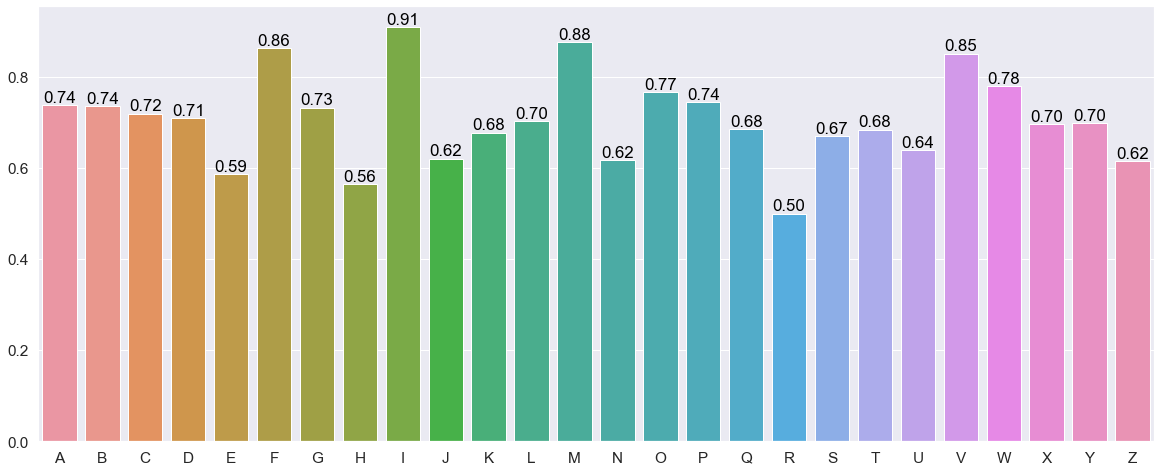

In [123]:
# lets plot the accuracies for each label
sns.set(rc = {'figure.figsize':(20,8)} , font_scale = 1.4)
sns.barplot(x=[chr(i+65) for i in range(26)], y=accuracyPerLabel)

# write values over the bars
for i, v in enumerate(accuracyPerLabel):
    plt.text(i, v, '{:.2f}'.format(v), color='black', ha='center', va='bottom')

plt.show()


### Confusion Matrix
Confusion matrix is a table that shows the number of correct and incorrect predictions made by the model. They gave us better understanding of the performance of the model.


In [133]:
# creating a confusion matrix
def createConfusionMatrix(model = model, testPredictions = testPredictions, testLabels = testLabels.values):
    """
    This function creates a confusion matrix for the model.
    """
    # create an empty matrix
    confusionMatrix = np.zeros((26, 26))
    # iterate over the predictions and labels
    for i in range(len(testPredictions)):
        # get the predicted label
        predictedLabel = testPredictions[i]
        # get the actual label
        actualLabel = testLabels[i]
        # increment the confusion matrix
        confusionMatrix[predictedLabel][actualLabel] += 1
    return confusionMatrix

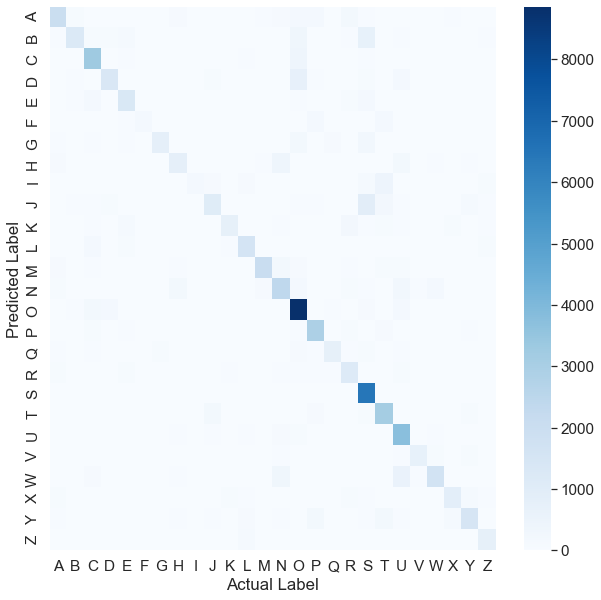

In [142]:
confusionMatrix  = createConfusionMatrix()
# plot the confusion matrix as a heat map
plt.figure(figsize=(10, 10))
sns.heatmap(confusionMatrix, cmap='Blues', xticklabels=[chr(i+65) for i in range(26)], yticklabels=[chr(i+65) for i in range(26)])
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()





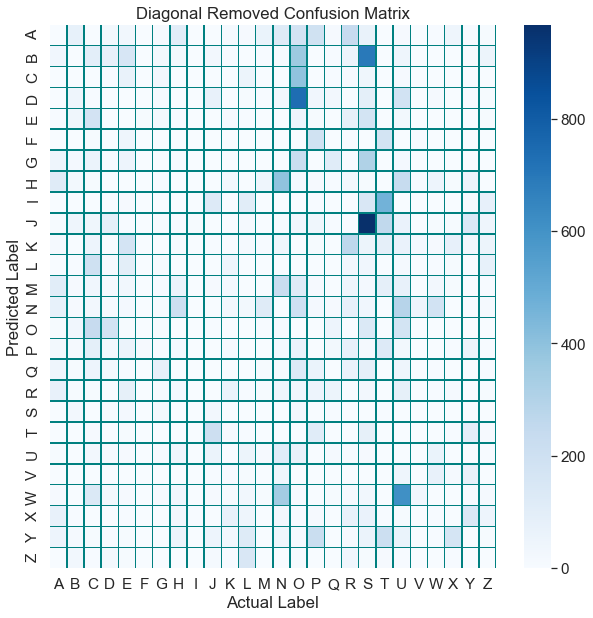

In [147]:
# plot the confusion matrix as a heat map by ignoring the diagonal
diagonalRemovedConfusionMatrix = np.zeros((26, 26))
for i in range(26):
    for j in range(26):
        if i != j:
            diagonalRemovedConfusionMatrix[i][j] = confusionMatrix[i][j]
        

plt.figure(figsize=(10, 10))
sns.heatmap(diagonalRemovedConfusionMatrix, cmap='Blues', xticklabels=[chr(i+65) for i in range(26)], yticklabels=[chr(i+65) for i in range(26)], linecolor='teal',linewidths=0.5)
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')
plt.title('Diagonal Removed Confusion Matrix')

# show boundaries

plt.show()

We can use the above matrix to see which letters are more wrongly predicted as which other letter